<a href="https://colab.research.google.com/github/DFazekas/Colab2_Fashion_MNIST/blob/master/Colab2_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classifying Images of Clothing
This neural network classifies images of clothing.

I'm leveraging the `tf.keras` API to build and train models in TensorFlow.

## Install and import dependencies

In [1]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 3.4MB 4.5MB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


In [2]:
import tensorflow as tf

# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np 
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

The dataset is from MNIST Fashion, containing 70,000 grayscale images of clothing in 10 categories. The images are low resolution (28 x 28 pixels).

Since our neural network will be trained by supervised learning, we'll set `as_supervised=True`.

In [3]:
dataset, metadata = tfds.load(
                              'fashion_mnist', 
                              as_supervised = True, 
                              with_info = True)

train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete7CEJ3H/fashion_mnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete7CEJ3H/fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


The images are (28 x 28) arrays, with pixel values in the range `[0, 255]`. 

The labels are an array of integers, in the range `[0, 9]`. These correspond to the class of clothing the image represents. E.g., `0 = "t-shirt"`, `1 = "trouser"`, etc.

Each image is mapped to a single label. Since the class names are not included with the dataset, we'll store them here to use later when plotting the images.

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

## Explore the data

The metadata provides insight into our datasets. For instance, here we can see the split ratio between the training and testing datasets.

In [5]:
num_train_examples  = metadata.splits['train'].num_examples
num_test_examples   = metadata.splits['test'].num_examples 

print("Number of training examples: {}".format(num_train_examples))
print("Number of testing examples: {}".format(num_test_examples))

Number of training examples: 60000
Number of testing examples: 10000


## Preprocess the data


The value of each pixel in an image is an integer in the range `[0, 255]`. For this model to work properly, these values need to be normalized (relative floats) to the range `[0, 1]`. 

So here, we create a normalization function, and then apply it to each image in the test and train datasets.

In [6]:
def normalize(images, labels):
  # Cast the pixel values from integers to floats.
  images = tf.cast(images, tf.float32)
  # Normalize the pixel values (percentage respective to 255).
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets.
train_dataset = train_dataset.map(normalize)
test_dataset  = test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk.
# Caching will keep them in memory, making training faster.
train_dataset = train_dataset.cache()
test_dataset  = test_dataset.cache()

## Explore the processed data

Let's display the first 25 images and their class names.

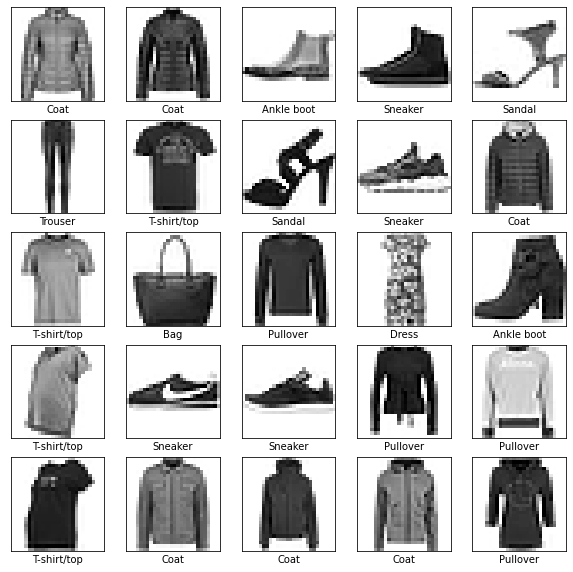

In [7]:
plt.figure(figsize = (10,10))               # (w,h) inches.

for i, (image, label) in enumerate(test_dataset.take(25)):
    plt.subplot(5, 5, i+1)                  # (nRows, nCols, index).
    plt.xticks([])                          # Remove x-tick marks.
    plt.yticks([])                          # Remove y-tick marks.
    plt.xlabel(class_names[label])          # Add x-labels.
    
    # `.imshow` accepts X and Y coordinates, but our images
    # contain three values (28,28,1). We need to remove the
    # excess value.
    # Reshape images: (28,28,1) -> (28,28).
    image = image.numpy().reshape((28, 28))
    plt.imshow(image, cmap = plt.cm.binary) # Gray-scale.
    
plt.show()

## Build the model

We need to configure the layers that make up our neural network, then compile the model.

### Setup the layers

Our neural network consists of three layers:
- **input**: `Flatten` -- transforms the image from a 2D-array of (28x28) pixels, to a 1D-array of (784) pixels.
- **hidden**: `Dense` -- densely connected layer of 128 neurons.
- **output**: `Dense` -- densely connected layer of 10 softmax neurons. Each neuron contains a value in range [0,1], representing the probability that the image belongs to that class; the sum of all 10 nodes equals 1.


In [8]:
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
                             tf.keras.layers.Dense(128, activation = tf.nn.relu),
                             tf.keras.layers.Dense(10,  activation = tf.nn.softmax)
])

### Compile the model

- **loss function**: `adam` -- an adaptive learning rate method, which means, it computes individual learning rates for different parameters.
- **optimizer**: `SpareCategoricalCrossentropy()` -- an algorithm for adjusting the inner parameters in order to minimize loss.
- **metrics**: `accuracy` -- used to monitor the training and testing tests.

In [9]:
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

## Train the model

To prevent our model from learning anything from the order of the examples, we need to shuffle the data.

Feeding in a batch of images speeds up training and reduces the noise in gradients, taking advantage of GPUs which are efficient at doing array operations.
There is no general rule of thumb as to which batch size works out best.

In [10]:
BATCH_SIZE    = 32
train_dataset = train_dataset.cache() \
                             .repeat() \
                             .shuffle(num_train_examples) \
                             .batch(BATCH_SIZE)

test_dataset  = test_dataset.cache().batch(BATCH_SIZE)

The number of interations is controlled by `epochs`. Here, we limit the training to 5 full iterations on the training dataset, so a total of (5 * 60,000) = 300,000 examples.

In [11]:
model.fit(train_dataset, 
          epochs = 5, 
          steps_per_epoch = math.ceil(num_train_examples / BATCH_SIZE)) 

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4954 - accuracy: 0.8263
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3751 - accuracy: 0.8638
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3341 - accuracy: 0.8795
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3123 - accuracy: 0.8849
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2902 - accuracy: 0.8942


## Evaluate accuracy


Now, we'll evaluate the accuracy of our model against the testing dataset.

In [12]:
test_loss, test_accuracy = model.evaluate(
                                          test_dataset, 
                                          steps = math.ceil(num_test_examples / BATCH_SIZE))
print('Accuracy on test dataset: {:.2f}%'.format(test_accuracy * 100))

313/313 [==============================] - 2s 6ms/step - loss: 0.3726 - accuracy: 0.8712
Accuracy on test dataset: 87.12%


## Make predictions

At this point, we have a trained model so let's use it to predict labels on unseen data.

In [13]:
for (test_images, test_labels) in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

Our model has predicted the labels for each image in the testing set. A prediction is an array of 10 numbers that represent the model's confidence that the image corresponds to each of the 10 different articles of clothing.

In [14]:
predictions[0]

array([4.2335039e-05, 1.1157031e-06, 1.8813664e-02, 1.6017496e-07,
       9.6770591e-01, 1.4199439e-10, 1.3433753e-02, 1.7704879e-11,
       3.1419129e-06, 2.2455048e-10], dtype=float32)

We can use `np.argmax` to extract the label with the highest confidence.

In [15]:
expected = class_names[test_labels[0]]
actual   = class_names[np.argmax(predictions[0])]

print("Actual ({}) | Expected ({})".format(actual, expected))

Actual (Coat) | Expected (Coat)


Let's graph all of the predictions.

In [16]:
def plot_image(predictions, actual_label, image):
  plt.grid(False)   # Remove grid.
  plt.xticks([])    # Remove x-axis tick marks.
  plt.yticks([])    # Remove y-axis tick marks.

  plt.imshow(img, cmap = plt.cm.binary) # Gray-scale color map.

  expected_label = np.argmax(predictions)
  
  # Color the prediction green if correct, red if incorrect.
  color = 'darkgreen' if (expected_label == actual_label) else 'red'
  
  plt.xlabel('{} {:2.0f}% ({})'.format(class_names[expected_label],
                                       100*np.max(predictions),
                                       class_names[actual_label]),
                                       color = color)
  
def plot_value_array(predictions, actual_label):
  plt.grid(False)                  # Remove grid.
  plt.xticks(range(len(class_names)), 
             class_names, 
             rotation='vertical',
             fontsize=8)           # Display class names are x-axis tick marks.
  plt.yticks([])                   # Remove y-axis tick marks.
  plt.ylim([0, 1])                 # Limit y-axis range [0,1].
  plot = plt.bar(range(10), predictions, color='#777777')
  
  expected_label = np.argmax(predictions)

  # If the expected and actual labels match, blend the colors to
  # illustrate the overlapping values.
  color = (['purple']*2) if (expected_label == actual_label) else ['lightblue', 'red']
  plot[expected_label].set_color(color[0])  # Expected label.
  plot[actual_label].set_color(color[1])    # Actual label.

Let's take a look at a single arbitary prediction made by our model.

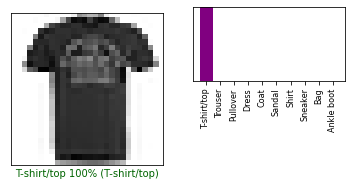

In [18]:
i = 6
preds     = predictions[i]          # Predicted labels.
actual    = test_labels[i]          # Actual labels.
img       = test_images[i][..., 0]  # Image pixel values (28,28). 

# Plot the image.
plt.figure(figsize = (6,3))
plt.subplot(1, 2, 1)                # (nRows, nCols, index).
plot_image(preds, actual, img)

# Plot the graph.
plt.subplot(2, 2, 2)                # (nRows, nCols, index).
plot_value_array(preds, actual)


It looks to be working at expected. Let's display the first 18 predictions.

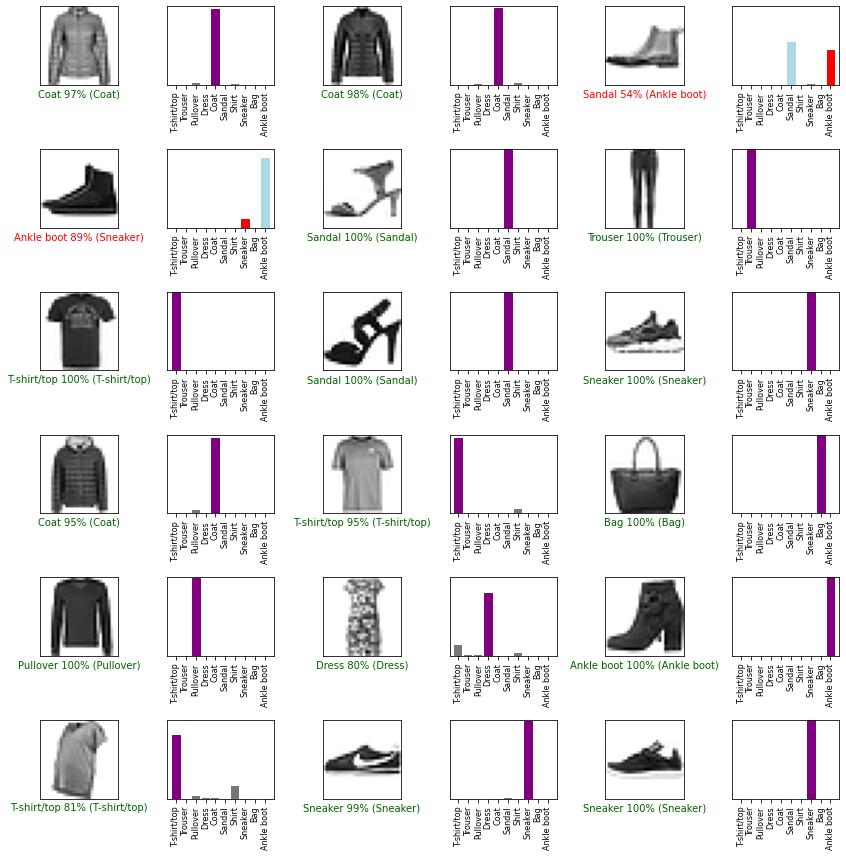

In [19]:
# Refactoring

# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows, num_cols = 6, 3
num_images         = num_rows * num_cols
plt.figure(figsize = ((2*2*num_cols), (2*num_rows)))

for i in range(num_images):
  preds     = predictions[i]          # Predicted labels.
  actual    = test_labels[i]          # Actual labels.
  img       = test_images[i][..., 0]  # Image pixel values (28,28). 

  plt.subplot(num_rows, (2*num_cols), (2*i+1))
  plot_image(preds, actual, img)
  plt.subplot(num_rows, (2*num_cols), (2*i+2))
  plt.tight_layout(h_pad=1.0, w_pad=0.1)
  plot_value_array(preds, actual)